# Anlyzing NYC High Schools Data

In this porject, we would like to explore relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

# Read in the data

In [3]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# function for standard bar chart
def plot_bar(num_cols):
    bar_heights = num_cols.values
    bar_positions = numpy.arange(len(num_cols)) + 0.75
    tick_positions = range(1,len(num_cols)+1)

    fig, ax = plt.subplots()
    ax.bar(left = bar_positions,
           height = bar_heights,
           width = 0.5)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(num_cols.index, rotation=90)
    sns.despine(bottom=True, left= True)
    return ax

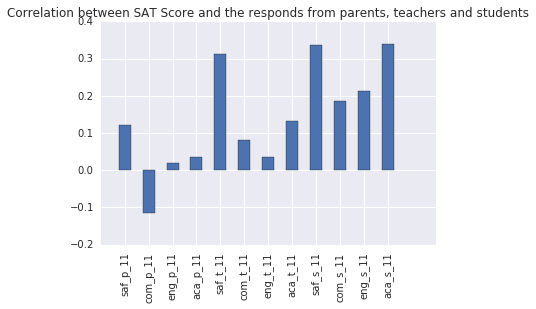

In [19]:
# find all columns with the responds from parents, teachers and students
pattern = r'_[pts]_'
num_cols = correlations[correlations.index.str.contains(pattern)]

ax = plot_bar(num_cols)
ax.set_title('Correlation between SAT Score and the responds from parents, teachers and students')

`saf_t_11`, `saf_s_11` and `aca_s_11` shows a relatively strong positive correlation towards SAT score. According to the data set's dictionary from the [City of New Yorks's website](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), they are *Safety and Respect score based on teacher responses*, *Safety and Respect score based on student responses* and *Academic expectations score based on student responses*. It indicates that the higher safety and respect obtained by the teachers and students, the higher the SAT score is expected. So does the expectation from the students themselves.

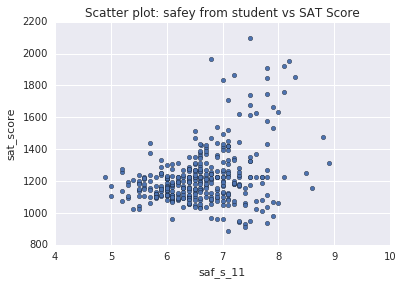

In [13]:
ax = combined.plot.scatter('saf_s_11', 'sat_score')
ax.set_title('Scatter plot: safey from student vs SAT Score')

Although most of the data has the `sat_score` between 1000 and 1400, we can still observe a tendency that the `sat_score` becomes more diverse when the `saf_s_11` increases. It is also interesting to notice that all schools with the `sat_score` higher than 1600 has a `saf_s_11` around 7 and 8, which is higher the the majority.

# Safety score of different boroughs

In [14]:
# average safety score based on students for each borough
avg_saf_s_11 = combined.groupby('boro')['saf_s_11'].agg('mean')
avg_saf_s_11

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

There is not much difference when we compare the satety score from different boroughs. Manhattan has the best safety score while Brooklyn has the worst. The range of sorce is about 0.45.

# Plotting racial correlations

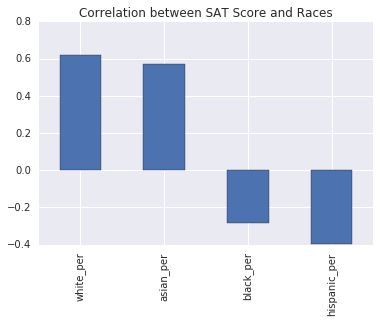

In [20]:
# selecting columns for races
num_cols = correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']]

ax = plot_bar(num_cols)
ax.set_title('Correlation between SAT Score and Races')

Above result shows that the percentage of white and asian has a positive correlation to SAT score and meanwhile the black and hispanic has a negative correlation.

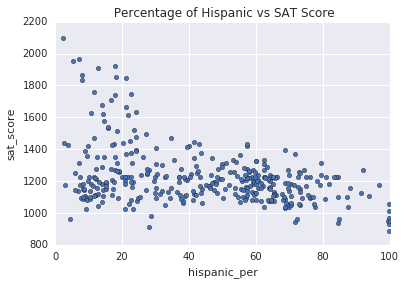

In [16]:
ax = combined.plot.scatter(x = 'hispanic_per',
                           y = 'sat_score')
ax.set_xlim(xmin = 0, xmax = 100)
ax.set_title('Percentage of Hispanic vs SAT Score')

The SAT score varys indrectly to the percentage of hispanic. In addition, there is an obvious change around 30% of hispanic: No schools with more than 30% obtains a SAT score above 1500. Moreover, schools with almost 100% of hispanic has the SAT score only around 1000.

In [40]:
combined.loc[combined['hispanic_per']>90, ['school_name','hispanic_per','boro']]

,school_name,hispanic_per,boro
44,Manhattan Bridges High School,99.8,Manhattan
80,City College Academy of the Arts,92.0,Manhattan
81,Community Health Academy of the Heights,93.8,Manhattan
82,Washington Heights Expeditionary Learning School,96.7,Manhattan
84,The College Academy,91.4,Manhattan
89,Gregorio Luperon High School for Science and M...,99.8,Manhattan
125,Academy for Language and Technology,99.4,Bronx
141,International School for Liberal Arts,99.8,Bronx
176,Pan American International High School at Monroe,99.8,Bronx
253,Multicultural High School,99.8,Brooklyn


More than a half of the school with more than 90% hispanic students are located in Manhattan and many students are immigrants who are still learning English.

In [41]:
combined.loc[(combined['hispanic_per']<10) & (combined['sat_score']>1800), ['school_name','hispanic_per','sat_score']]

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0
356,Staten Island Technical High School,5.3,1953.0


All of these schools require an special admission test, [SHSAT (Specialized High Schools Admissions Test)](https://en.wikipedia.org/wiki/Specialized_High_Schools_Admissions_Test), so that to ensure they have the best students in town.

# Plotting gender correlation

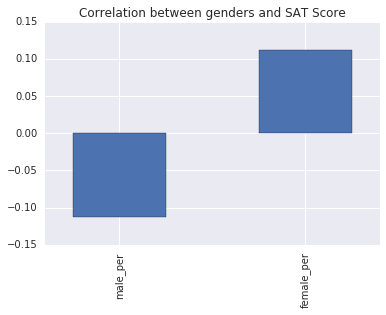

In [21]:
# select columns for genders
num_col = correlations[['male_per','female_per']]

ax = plot_bar(num_col)
ax.set_title('Correlation between genders and SAT Score')

Female is slightly positive correlated to SAT score while male is the opposite.

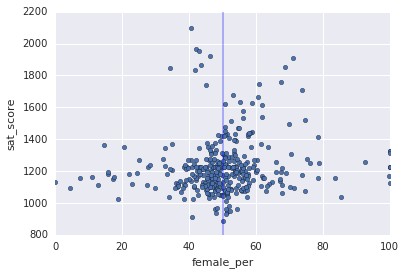

In [35]:
ax = combined.plot.scatter(x='female_per',
                           y='sat_score')
ax.set_xlim(xmin=0,xmax=100)
plt.axvline(x=50, alpha = 0.3)

Although we can see more schools with high SAT score exists on the higher female percentage side, there are still a group of schools with lower female percentage has the top SAT score.

In [38]:
combined.loc[(combined['female_per'] > 60) & (combined['sat_score']>1700),['school_name', 'female_per', 'sat_score', 'boro']]

,school_name,female_per,sat_score,boro
5,Bard High School Early College,68.7,1856.0,Manhattan
26,Eleanor Roosevelt High School,67.5,1758.0,Manhattan
60,Beacon High School,61.0,1744.0,Manhattan
61,Fiorello H. LaGuardia High School of Music & A...,73.6,1707.0,Manhattan
302,Townsend Harris High School,71.1,1910.0,Queens


4 out of 5 schools with more than 60% female with a SAT score higher than 1700 are located in Manhatten.

# AP Test correlation

Since `AP Test Takers` depends also on `total_enrollment`, we will use the ratio of AP test takers to compare with SAT score.

(0, 1)

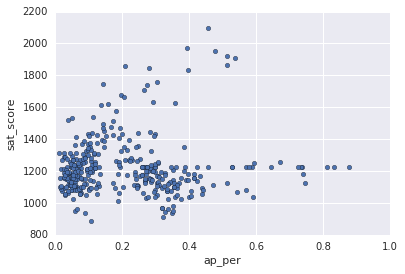

In [47]:
# create AP test takers ratio`
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

ax = combined.plot.scatter(x='ap_per',
                           y='sat_score')
ax.set_xlim(xmin=0,xmax=1)

The SAT score has a positive correlation with AP ratio but only until 60%. For those with higher AP ratio seems to be independent to SAT score, which around 1200.